In [1]:
# import libraries
import random
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import cascaded_union
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
import FrameworkLib as FL
import numpy as np

In [2]:
# graph analysis
x_limit = (-10, 10)
y_limit = (-10, 10)
total_area = (x_limit[1] - x_limit[0]) * (y_limit[1] - y_limit[0])

agent_radius = 2
area_of_each_agent = np.pi*agent_radius**2

max_range = 10

num_iterations = int(5e2)
range_num_agents = range(4, 30, 1)
# num_iterations = int(1e3)
# range_num_agents = np.array([10])

fourth_eigenvalues = []
energy = []
coverage = []
connectivity = []

for num_agents in range_num_agents:    
    # for _ in range(num_iterations):
    counter = 0
    while counter < num_iterations:
        # Generate random agents
        agents = [(random.uniform(*x_limit), random.uniform(*y_limit)) for _ in range(num_agents)]
        
        # Create a new graph
        G = nx.Graph()
        for i, agent in enumerate(agents):
            G.add_node(i, pos=agent)
        for i in range(num_agents):
            for j in range(i + 1, num_agents):
                distance = ((agents[i][0] - agents[j][0]) ** 2 + (agents[j][1] - agents[i][1]) ** 2) ** 0.5
                if distance <= max_range:
                    G.add_edge(i, j)
        
        # Compute the rigidity matrix
        R, RR, E, V = FL.calculate_rigidity_matrix(G)

        
        # Compute eigenvalues
        eigenvalues = sorted(E, key=lambda x: x.real)
        
        # Store the 4th eigenvalue in ascending order
        if len(eigenvalues) >= 4 and eigenvalues[3] > 1e-4:            
            
            # energy
            energy_measure = FL.measure_energy(G)            
            
            # coverage
            agent_circles = [Point(agent).buffer(agent_radius) for agent in agents]
            union_area = cascaded_union(agent_circles).area
            coverage_measure = union_area / total_area
            
            # measure connectivity
            connectivity_measure = FL.measure_connectivity(G)
                        
            counter += 1
            fourth_eigenvalues.append(eigenvalues[3])
            energy.append(energy_measure)
            coverage.append(coverage_measure)
            connectivity.append(connectivity_measure)        



In [3]:
# data selection
fourth_eigenvalues_origin = np.array(fourth_eigenvalues)
energy_origin = np.array(energy)
coverage_origin = np.array(coverage)
connectivity_origin = np.array(connectivity)

# data filtering
if 1:
    threshold = 60
    pos = (fourth_eigenvalues_origin > 1*threshold)
    fourth_eigenvalues = fourth_eigenvalues_origin[pos]
    energy = energy_origin[pos]
    coverage = coverage_origin[pos]
    connectivity = connectivity_origin[pos]

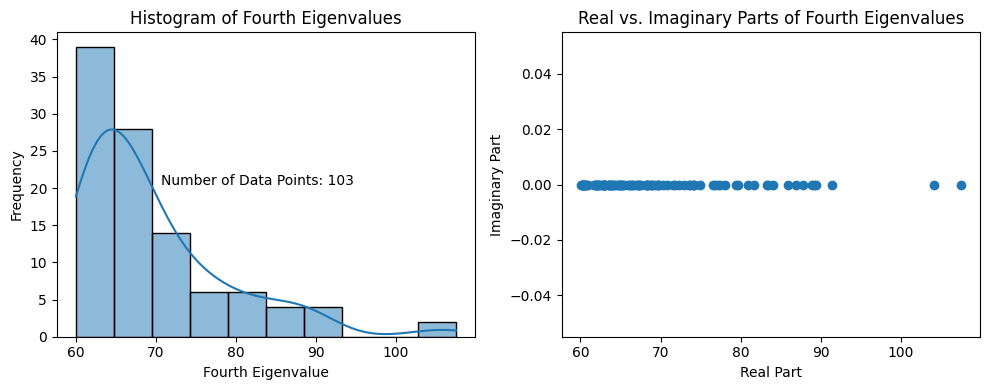

In [4]:
FL.plot_histograms(fourth_eigenvalues)

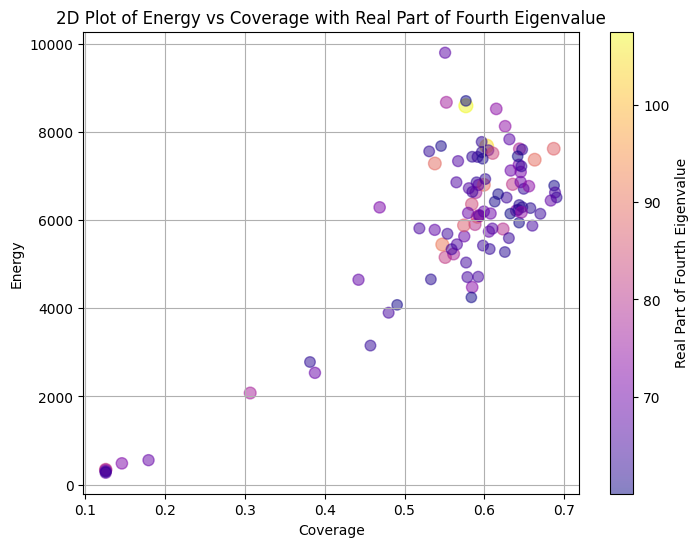

In [5]:
FL.plot_coverage_energy(fourth_eigenvalues, coverage, energy, 100)

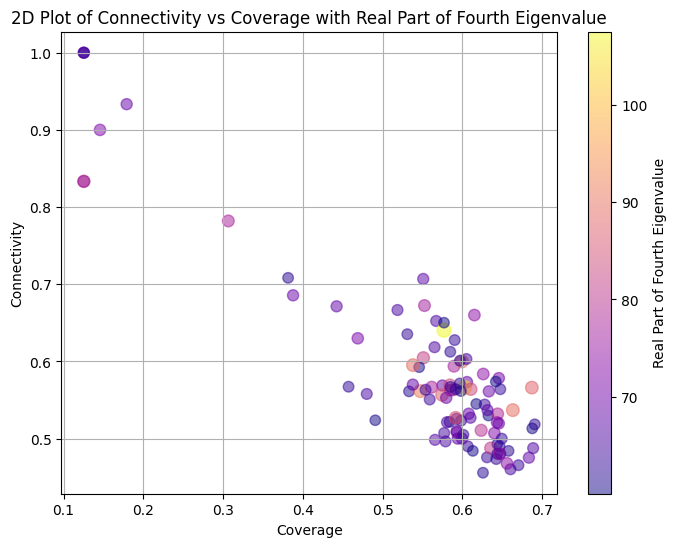

In [6]:
FL.plot_coverage_connectivity(fourth_eigenvalues, coverage, connectivity,100)

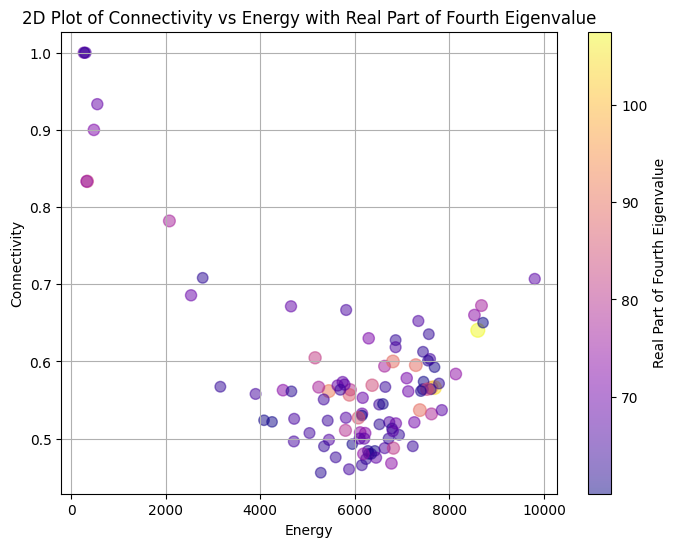

In [7]:
FL.plot_energy_connectivity(fourth_eigenvalues, energy, connectivity, 100)

In [8]:
FL.plot_3D_vis(fourth_eigenvalues, coverage, energy, connectivity)